# Exercise 05:  Solving differential equation-based Bayesian inverse problems using CUQIpy

Here we build a Bayesian problem in which the forward model is a partial differential equation model, 1D Heat problem in particular.

**Try to at least run through part 1 to 4 before working on the optional exercises**

## Learning objectives of this notebook:
- Solve PDE-based Bayesian problem using CUQIpy.
- Parametrization of the Bayesian parameters (e.g. KL expansion, non-linear maps).

## Table of contents: 
* [1. Loading the PDE test problem](#PDE_model)
* [2. Building and solving the Bayesian inverse problem](#inverse_problem)
* [3. Parametrizing the Bayesian parameters via step function expansion](#step_function)
* [4. Observe on part of the domain](#Partial_Observation) ★
* [5. Parametrizing the Bayesian parameters via KL expansion](#KL_expansion) ★


##  1. Loading the PDE test problem <a class="anchor" id="PDE_model"></a>

We first import the required python standard packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor
import sys
sys.path.append("../../CUQIpy/")

From cuqi package, we import the classes that we use in this exercise:

In [2]:
from cuqi.geometry import MappedGeometry, KLExpansion
from cuqi.pde import SteadyStateLinearPDE
from cuqi.distribution import GaussianCov, Posterior, Gaussian, JointDistribution
from cuqi.sampler import pCN, MetropolisHastings, CWMH
from cuqi.testproblem import Heat_1D
from cuqi.operator import FirstOrderFiniteDifference
from cuqi.pde import SteadyStateLinearPDE

We load the test problem `Heat_1D` which provides a one dimensional (1D) time dependent heat model with zero boundary conditions. The model is discretized using finite difference.

The PDE is given by:

$$ \frac{\partial u(x,t)}{\partial t} - c^2 \Delta_x u(x,t)   = f(x,t), \;\text{in}\;\Omega=[0,L] $$
$$u(0,t)= u(L,t)= 0 $$

where $u(x,t)$ is the temperature and $c^2$ is the thermal diffusivity (assumed to be 1 here). We assume the source term $f$ is zero. The unknown Bayesian parameters for this test problem is the initial heat profile $\theta(x):=u(x,0)$. The data $\mathbf{d}$ are the temperature measurements everywhere in the domain at the final time $T$.

Before we load the `Heat_1D` problem, let's set the parameters: final time $T$, number of finite difference nodes $N$, and the length of the domain $L$

In [3]:
N = 30  # number of finite difference nodes            
L = 1    # Length of the domain
T = 0.02  # Final time

We choose the initial condition (the exact solution for the Bayesian problem) to be a step function with three pieces.

In [35]:
n_steps = 3
n_steps_values = [0,1,2]
myExactSolution = np.zeros(N)

start_idx=0
for i in range(n_steps):
    end_idx = floor((i+1)*N/n_steps)
    myExactSolution[start_idx:end_idx] = n_steps_values[i]
    start_idx = end_idx

We plot the exact solution:

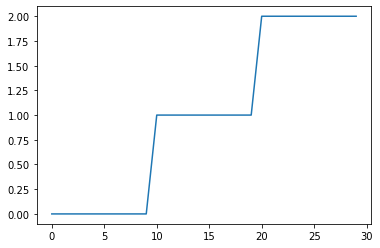

In [36]:
plt.plot(myExactSolution)

We load `Heat_1D` using `get_components` method. We can explore `Heat_1D` initialization parameters (which are the same parameters that can be passed to `get_components` method) by calling `Heat_1D?`. 

In [37]:
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T, exactSolution=myExactSolution)

Lets take a look at what we obtain from the test problem. We view the `model`:

In [38]:
model

CUQI PDEModel: Continuous1D(30,) -> Continuous1D(30,). Forward parameters: ['x']. PDE: TimeDependentLinearPDE

We can look at the returned `data`:

In [39]:
data

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 Continuous1D(30,)

Parameters:
 True

Array:
CUQIarray([0.03614648, 0.09018073, 0.07904874, 0.1535625 , 0.17846859,
           0.24193576, 0.29174038, 0.37858772, 0.44795511, 0.46896438,
           0.61120061, 0.6430827 , 0.74159626, 0.88671089, 0.92676185,
           1.03499469, 1.07143259, 1.13007856, 1.18886779, 1.26285704,
           1.26232696, 1.26525462, 1.26451776, 1.20815251, 1.09677671,
           0.91409213, 0.85683086, 0.64566812, 0.43603678, 0.22714365])

And the `problemInfo`:

In [40]:
problemInfo

ProblemInfo with the following set attributes:
['exactSolution', 'infoString', 'exactData']
 infoString: Noise type: Additive i.i.d. noise with mean zero and signal to noise ratio: 200

Now lets plot the exact solution of this inverse problem and the exact and noisy data:

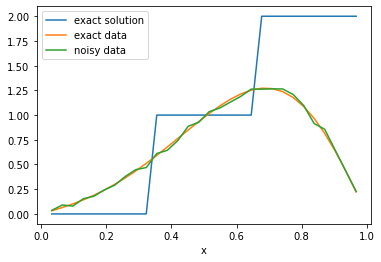

In [41]:
problemInfo.exactSolution.plot()
problemInfo.exactData.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

Note that the values of the initial solution and the data at 0 and $L$ are not included in this plot.


#### Try yourself (optional)
* The data plotted above were generated from the model. Confirm that the model actually generate this data (the exact data) by applying `model.forward` on the exact solution (the initial heat profile).
* Can you view the heat profile at time T= 0.001. What do you notice. (hint: you can do that by choosing different final time when loading `Heat_1D`. Be sure to use different variable names for the returned `model`, `data` and `problemInfo` because they are used in section 2. You can use for example `model_t2`, `data_t2` and `problemInfo_t2`) 

## 2. Building and solving the Bayesian inverse problem <a class="anchor" id="inverse_problem"></a>

The joint distribution of the data $y$ and the parameter $x$ is given by

$$p(x,y) = p(y|x)p(x)$$



Where $p(x)$ is the prior pdf, $p(y|x)$ is the data distribution pdf. We start by defining the prior distribution $\Pi(x)$:

In [42]:
mean = 0
std = 1.2
x = Gaussian(mean*np.ones(N), std, geometry= model.domain_geometry) # The prior distribution


#### Try yourself (optional)
* create prior samples (~1 line).
* plot the 95% credibility interval of the prior samples (~1 line).
* look at the 95% credibility interval of the PDE model solution to quantify the forward uncertainty (~2 lines).


In [43]:
# Your code here



To define the data distribution $\Pi(y|x)$, we first estimate the noise level. Because here we know the exact data, we can estimate the noise level as follows:

In [44]:
sigma_data = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level

And then define the data distribution $\Pi(y|x)$: 

In [45]:
y = Gaussian(mean=model, std=sigma_data, geometry=model.range_geometry)

Now that we have all the components we need, we can create the joint distribution $\Pi(x,y)$, from which the posterior distribution can be created by setting $y=\texttt{data}$:

The joint distribution $\Pi(x,y)$:

In [46]:
joint =  JointDistribution(y, x)
print(joint)

JointDistribution(
    Equation: 
	p(y,x) = p(y|x)p(x)
    Densities: 
	y ~ CUQI Gaussian. Conditioning variables ['x'].
	x ~ CUQI Gaussian.
)


The posterior distribution pdf is given by the Bayes rule:
$$ p(x|y=\text{data}) \propto p(y=\text{data}|x)p(x) $$ 
By setting $y=\texttt{data}$ in the joint distribution we obtain the posterior distribution:

In [47]:
posterior = joint(y=data)
print(posterior)


JointDistribution(
    Equation: 
	p(x|y) ∝ L(x|y)p(x)
    Densities: 
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
	x ~ CUQI Gaussian.
)


We convert the joint distribution to an object of type posterior (this is a temporary hack and in the near future samplers will be able to sample `JointDistributions` directly):

In [48]:
posterior = posterior._reduce_to_single_density() #TODO: eventually remove this line
print(posterior)

Posterior(
    Equation:
	 p(x|y) ∝ L(x|y)p(x)
    Densities:
	y ~ CUQI Gaussian Likelihood function. Parameters ['x'].
 	x ~ CUQI Gaussian.
 )


We can now sample the posterior. Lets try the preconditioned Crank-Nicolson (pCN) sampler (~60 seconds):

In [49]:
MySampler = pCN(posterior)
posterior_samples = MySampler.sample_adapt(20000)

/Users/amal/Library/Python/3.8/lib/python/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


 Sample 20000 / 20000

Average acceptance rate: 0.30875 MCMC scale: 0.04471717616451406 



Let's look at the $95\%$ credible interval:

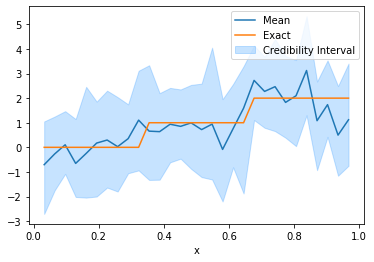

In [50]:
posterior_samples.plot_ci(95, exact = problemInfo.exactSolution)

We can see that the mean reconstruction of the initial solution matches the general trend of the exact solution to some extent but it does not capture the piece-wise constant nature of the exact solution.

Also we note that since the heat problem has zero boundary conditions, the initial solution reconstruction tend to go to zero at the boundaries. 

## 3. Parametrizing the Bayesian parameters via step function expansion <a class="anchor" id=" step_function"></a> 

One way to improve the solution of this Bayesian problem is to use better prior information. Here we assume the prior is a step function with three pieces. This also makes the Bayesian problem simpler because now we only have three Bayesian parameters to infer.

To test this case we pass `field_type='Step'` to `Heat_1D.get_components`, which creates a `StepExpansion` domain geometry for the model during initializing the `Heat_1D` test problem.

In [51]:
n_steps = 3 # number of steps in the step expansion domain geometry
N=30
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T,field_type='Step', n_steps=n_steps, exactSolution = myExactSolution)

Lets look at the `model` in this case: 

In [52]:
model

CUQI PDEModel: StepExpansion(3,) -> Continuous1D(30,). Forward parameters: ['x']. PDE: TimeDependentLinearPDE

We then continue to create the Bayesian problem (prior, data distribution and posterior) with a prior of dimension = n_steps. 

In [53]:
# Prior
x = Gaussian(mean*np.ones(n_steps), std, geometry= model.domain_geometry)

# Data distribution
sigma_data = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level
y = Gaussian(mean=model, std=sigma_data, geometry=model.range_geometry)

And the posterior:

In [54]:
joint =  JointDistribution(y, x)
posterior = joint(y=data)
posterior = posterior._reduce_to_single_density()

We then sample the posterior using pCN (~60 seconds)

In [55]:
MySampler = MetropolisHastings(posterior)
posterior_samples = MySampler.sample_adapt(25000)

/Users/amal/Library/Python/3.8/lib/python/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Sample 25000 / 25000

Average acceptance rate: 0.08224 MCMC scale: 0.04561657523312966 



Let's take a look at the posterior:

(3, 25000)

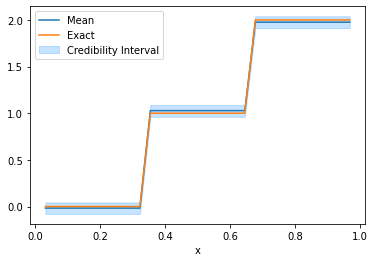

In [56]:
posterior_samples.plot_ci(95, exact = problemInfo.exactSolution)
posterior_samples.shape

We show the trace plot: a plot of the kernel density estimator (left) and chains (right) of the `n_steps` variables:

array([[<AxesSubplot:title={'center':'v0'}>,
        <AxesSubplot:title={'center':'v0'}>],
       [<AxesSubplot:title={'center':'v1'}>,
        <AxesSubplot:title={'center':'v1'}>],
       [<AxesSubplot:title={'center':'v2'}>,
        <AxesSubplot:title={'center':'v2'}>]], dtype=object)

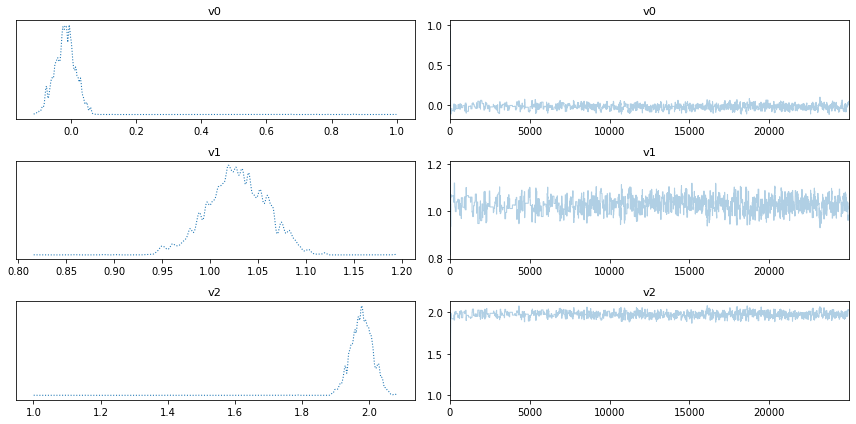

In [57]:
posterior_samples.plot_trace()

We show pair plot of 2D marginal posterior distributions: 

array([[<AxesSubplot:ylabel='v1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='v0', ylabel='v2'>,
        <AxesSubplot:xlabel='v1'>]], dtype=object)

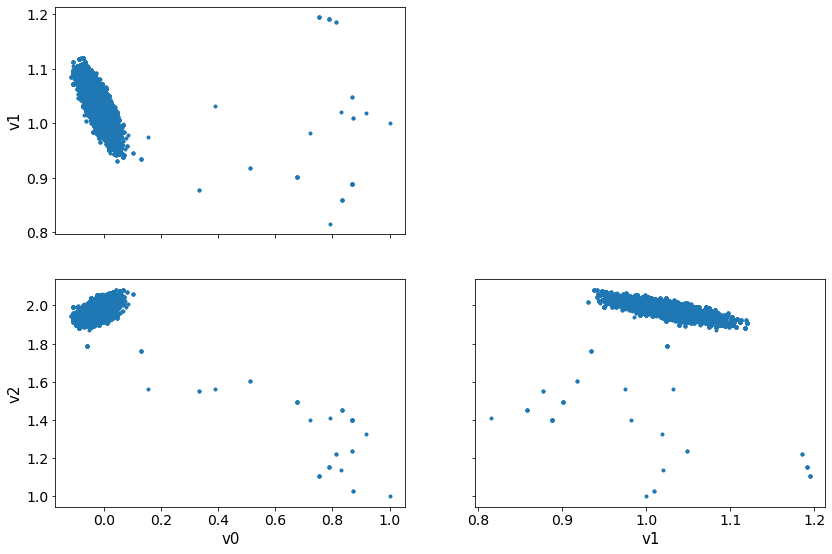

In [58]:
posterior_samples.plot_pair()

We notice that there seem to be some burn-in samples until the chain reaches the high density region. We show the pair plot after removing 200 burn-in:

array([[<AxesSubplot:ylabel='v1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='v0', ylabel='v2'>,
        <AxesSubplot:xlabel='v1'>]], dtype=object)

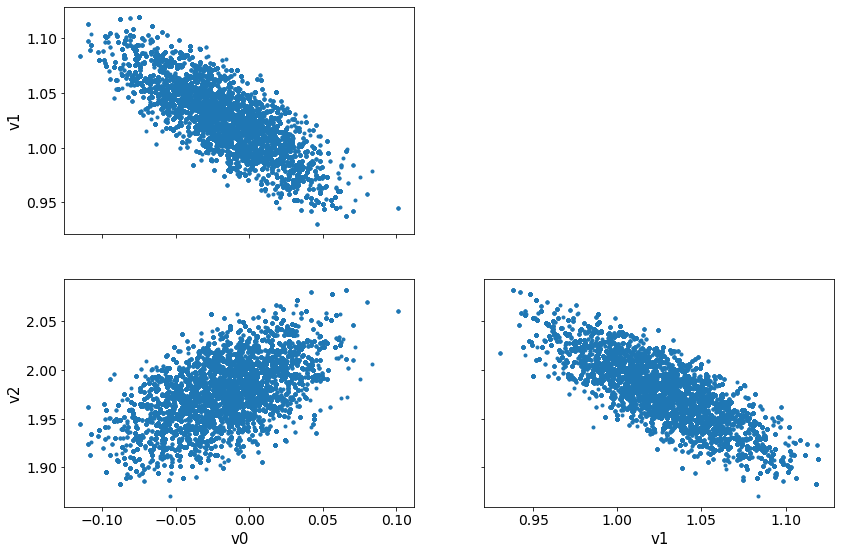

In [59]:
posterior_samples.burnthin(200).plot_pair()

We can see that visually the burn-in is indeed removed. Another observation here is the clear correlation between each pair of the variables.

We compute the effective sample size (ESS) which approximately gives the number of independent samples in the chain:

In [60]:
import arviz as az
az.ess(posterior_samples.to_arviz_inferencedata())
#posterior_samples.compute_ess()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    v0       float64 501.5
    v1       float64 459.7
    v2       float64 508.1

#### Try it yourself (optional):
* For this step function parametrization, try to enforce positivity of the posterior samples via passing `map = lambda x : np.exp(x)` to the `Heat_1D.get_components` method. Then run the pCN sampler again (similar to part 3).

In [30]:
# Your code here



* Try to solve the same inverse problem of section 3, but with different number of steps. e.g. 4. Note that for this configuration heat_1D will generate an exact solution with `n_steps` steps, so you do not need to pass the exact solution.

In [ ]:
# Your code here



## 4. Observe on part of the domain <a class="anchor" id="Partial_Observation"></a> ★

Here we solve the same problem as in section 3 but with observing the data only on the right half of the domain.  

We chose the number of steps to be 4:

In [61]:
N=30
n_steps = 4 # Number of steps in the StepExpansion geometry. 

Then we write the `observation_location` map which is can be passed to the `Heat_1D`.
It is a lambda function that takes the range_grid as input and generate a sub grid of the nodes where we have observations (data). 

In [62]:
observation_nodes = lambda x: x[np.where(x>L/2)] # observe in the right half of the domain

In [63]:

model, data, problemInfo = Heat_1D.get_components(
    dim=N, endpoint=L, max_time=T, field_type='Step', n_steps=n_steps, observation_nodes=observation_nodes)


Now lets plot the exact solution of this inverse problem and the exact and noisy data:

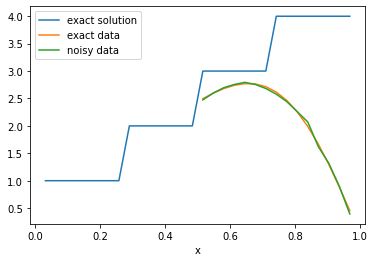

In [64]:
problemInfo.exactSolution.plot()
problemInfo.exactData.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

We then continue to create the Bayesian problem (prior, data distribution and posterior) with a prior of dimension = 4. 

In [65]:
# Prior
x = Gaussian(2*np.ones(n_steps), std, geometry= model.domain_geometry)

# Data distribution
sigma_data = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level
y = Gaussian(mean=model, std=sigma_data, geometry=model.range_geometry)

And the posterior:

In [66]:
joint =  JointDistribution(y, x)
posterior = joint(y=data)
posterior = posterior._reduce_to_single_density()

We then sample the posterior using pCN (~60 seconds)

In [72]:
MySampler = CWMH(posterior, x0=np.zeros(posterior.dim))
posterior_samples = MySampler.sample_adapt(5000)

Sample 5000 / 5000

Average acceptance rate all components: 0.134 



Let's take a look at the posterior:

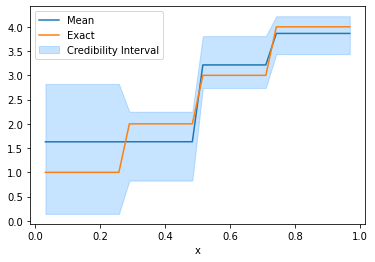

In [73]:
posterior_samples.plot_ci(95, exact = problemInfo.exactSolution)

We see that the credible interval is wider on the side of the domain where data is not available (the left side) and narrower as we get to the right side of the domain.

## 5 Parametrizing the Bayesian parameters via KL expansion ★

Here we explore the Bayesian inversion for a more general exact solution. We parametrize the Bayesian parameters using Karhunen–Loève (KL) expansion. This will represent the inferred heat initial profile as a linear combination of sine functions. 
$$ u(x,0) = \sum_i \theta_i  (1/i)^{\text{decay}}  sin(\frac{i L x}{\pi}). $$
Where $\theta_i$ are the Bayesian parameters. 

Lets load the Heat_ID test case and pass `field_type = 'KL'`, which behind the scenes will set the domain geometry of the model to be a KL expansion geometry (`KLExpansion`):

In [ ]:
N=35
model, data, problemInfo = Heat_1D.get_components(dim=N, endpoint=L, max_time=T, field_type = 'KL' )

Now we inspect the `model.domain_geometry`:

In [ ]:
model.domain_geometry

And the exact solution and the data:

In [ ]:
problemInfo.exactSolution.plot()
problemInfo.exactData.plot()
data.plot()
plt.legend(['exact solution', 'exact data', 'noisy data']);

Note that the exact solution here is a general signal that is not constructed from the basis functions. We define the prior $p(x)$:

In [ ]:
sigma_prior = 9*np.ones(model.domain_dim) #1, 9
x = GaussianCov(mean*np.ones(N), sigma_prior, geometry= model.domain_geometry)

We define the data distribution:

In [ ]:
sigma_data = np.std(problemInfo.exactData - data)*np.ones(model.range_dim) # noise level
y = Gaussian(mean=model, std=sigma_data, geometry=model.range_geometry).to_likelihood(data)

And the posterior distribution:

In [ ]:
joint =  JointDistribution(y, x)
posterior = joint(y=data)
posterior = posterior._reduce_to_single_density()


We sample the posterior, here we use Component-wise Metropolis Hastings (~90 seconds):

In [ ]:

MySampler = CWMH(posterior, x0=np.ones(N))
posterior_samples = MySampler.sample_adapt(2000)

And plot the $95\%$ credibility interval (you can try plotting different credibility intervals, e.g. $80\%$) 

In [ ]:
posterior_samples.plot_ci(95, exact = problemInfo.exactSolution)

The credibility interval can have zero width at some locations where the upper and lower limit seems to intersect and switch order (uppers becomes lower and vice versa). To look into what actually happen here, we plot some samples:

In [ ]:
posterior_samples_burnthin = posterior_samples.burnthin(0,10)
for i, s in enumerate(posterior_samples_burnthin):
    model.domain_geometry.plot(s)

The samples seem to paint a different picture than what the credibility interval plot shows. Note that the computed credibility interval above, is computed on the domain geometry parameter space, then converted to the function space for plotting. We can alternatively convert the samples to function values first, then compute and plot the credibility interval.

Convert samples to function values:

In [ ]:
funvals_samples = posterior_samples.funvals

Then plot the credibility interval computed from the function values:

In [ ]:
funvals_samples.plot_ci(95, exact = problemInfo.exactSolution)

We can see that the credibility interval now reflect what the samples plot shows and does not have these locations where the upper and lower bounds intersect.

Let's look at the effective sample size (ESS):

In [ ]:
az.ess(posterior_samples.to_arviz_inferencedata())

We note that the ESS varies considerably among the variables. We can view the trace plot for, let's say, the first and the second variables:

In [ ]:
posterior_samples.plot_trace([0,1])

A third way of looking at the credibility intervals, is to look at the expansion coefficients  $\theta_i$ credibility intervals. We plot the credibility intervals for these coefficients from both prior  and posterior samples by passing the flag `plot_par=True` to `plot_ci` function:

The prior:

In [ ]:
plt.figure()
x.sample(1000).plot_ci(95, plot_par=True)
plt.xticks(np.arange(x.dim)[::5]);

The posterior:

In [ ]:
posterior_samples.plot_ci(95, plot_par=True)
plt.xticks(np.arange(x.dim)[::5]);